<a href="https://colab.research.google.com/github/Ordo-Umbra/Void-Defect-Model/blob/main/vdmengine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh  # For bound state solver

class VDMEngine:
    def __init__(self, dims=3, N_initial=500, steps=100, dt=0.001, chaos_lambda=0.8, damping=0.8,
                 threshold_I=0.5, max_N=1000, repulsion_on=True, rng_seed=42):
        self.dims = dims
        self.N_initial = N_initial
        self.steps = steps
        self.dt = dt
        self.chaos_lambda = chaos_lambda
        self.damping = damping
        self.threshold_I = threshold_I
        self.max_N = max_N
        self.repulsion_on = repulsion_on
        self.rng = np.random.default_rng(rng_seed)

        # Initial state
        self.positions = self.rng.uniform(-1, 1, (N_initial, dims))
        self.velocities = self.rng.uniform(-0.1, 0.1, (N_initial, dims))
        self.E = np.ones(N_initial) * 5.0  # Base energy
        spin_dims = 3 if dims == 3 else 1
        self.S = self.rng.uniform(-0.5, 0.5, (N_initial, spin_dims))  # Spin: (N, spin_dims)
        self.pos_history = [self.positions.copy()]
        self.N = N_initial

        # For bound states
        self.V0 = 10.0  # Default for Gaussian well
        self.sigma_bound = 2.0  # For bound solver

    def compute_Phi_and_grad(self, positions, E, sigma):
        """Compute curvature field Phi and its gradient."""
        diffs = positions[:, np.newaxis] - positions
        dists_sq = np.sum(diffs**2, axis=2)
        kernel = np.exp(-dists_sq / (2 * sigma**2))
        Phi = np.sum(kernel * E[np.newaxis, :], axis=1)

        weighted_diffs = E[np.newaxis, :, np.newaxis] * kernel[:, :, np.newaxis] * diffs
        grad = -np.sum(weighted_diffs, axis=1) / sigma**2

        # Repulsion
        if self.repulsion_on:
            dists = np.sqrt(dists_sq + 1e-8)
            min_dist = np.mean(dists[dists > 0]) / 10
            rep_strength = np.mean(E)
            close_mask = (dists < min_dist) & (dists > 0)
            rep_diffs = np.where(close_mask[:, :, np.newaxis], diffs / (dists[:, :, np.newaxis]**3), 0)
            rep_grad = rep_strength * np.sum(E[:, np.newaxis, np.newaxis] * rep_diffs, axis=0)
            grad += rep_grad

        return grad, kernel, diffs, Phi

    def bound_state_spectra(self, V0=None, sigma=None):
        """Solve 1D radial Schrodinger for bound states in Gaussian well."""
        if V0 is None: V0 = self.V0
        if sigma is None: sigma = self.sigma_bound
        L = 20 * sigma  # Box size
        N_grid = 512
        x = np.linspace(-L, L, N_grid)
        dx = x[1] - x[0]
        V = -V0 * np.exp(-x**2 / (2 * sigma**2))

        # FIXED Kinetic operator: for -d²/dx²
        T = np.diag(2 * np.ones(N_grid), 0) + np.diag(-np.ones(N_grid-1), 1) + np.diag(-np.ones(N_grid-1), -1)
        T /= dx**2
        H = T + np.diag(V)

        # Solve for lowest eigenvalues (bound states E < 0)
        evals = eigh(H, eigvals_only=True, subset_by_index=[0, 10])  # Top 10 lowest
        bound_evals = evals[evals < 0]
        return bound_evals

    def tick(self):
        """Single tick update."""
        # Emergent sigma
        dist_matrix = np.linalg.norm(self.positions[:, np.newaxis] - self.positions, axis=2)
        sigma = np.mean(dist_matrix[dist_matrix > 0]) / np.sqrt(2) if self.N > 1 else 1.0

        grad, kernel, diffs, Phi = self.compute_Phi_and_grad(self.positions, self.E, sigma)
        force_mags = np.linalg.norm(grad, axis=1)

        # Spawn logic
        spawn_threshold = np.mean(Phi)
        spawn_prob_base = self.chaos_lambda * np.std(force_mags) if np.std(force_mags) > 0 else 0.406
        spawns = []
        for i in range(self.N):
            if force_mags[i] > spawn_threshold and self.rng.random() < spawn_prob_base * (force_mags[i] / spawn_threshold):
                closest_j = np.argmin(dist_matrix[i] + 1e6 * (np.arange(self.N) == i))
                mid_point = (self.positions[i] + self.positions[closest_j]) / 2
                new_pos1 = mid_point + self.rng.normal(0, 0.1, self.dims)
                new_pos2 = mid_point + self.rng.normal(0, 0.1, self.dims)
                new_vel1 = self.rng.uniform(-0.1, 0.1, self.dims)
                new_vel2 = self.rng.uniform(-0.1, 0.1, self.dims)
                new_E = self.E[i] / 2
                new_S = self.S[i] / 2
                spawns.append((new_pos1[None, :], new_pos2[None, :], new_vel1[None, :], new_vel2[None, :],
                               new_E, new_E, new_S[None, :], new_S[None, :]))  # new_S[None,:] for (1, spin_dims)

        # Apply spawns
        for p1, p2, v1, v2, e1, e2, s1, s2 in spawns:
            if self.N >= self.max_N:
                break
            self.positions = np.vstack([self.positions, p1, p2])
            self.velocities = np.vstack([self.velocities, v1, v2])
            self.E = np.append(self.E, [e1, e2])
            self.S = np.vstack([self.S, s1, s2])  # Always vstack, s1/s2 are (1, spin_dims)
            self.N += 2

        # Recompute post-spawn
        dist_matrix = np.linalg.norm(self.positions[:, np.newaxis] - self.positions, axis=2)
        sigma = np.mean(dist_matrix[dist_matrix > 0]) / np.sqrt(2) if self.N > 1 else 1.0
        grad, kernel, diffs, Phi = self.compute_Phi_and_grad(self.positions, self.E, sigma)

        # Stall mask
        Phi_crit = np.max(Phi) / 2 if np.max(Phi) > 0 else 15.0
        stall_mask = Phi > Phi_crit
        self.velocities[stall_mask] *= 0.1

        # Spin update (torque=0 for central forces)
        spin_dims = self.S.shape[1]
        if self.dims == 2:
            S_scalar = self.S[:, 0].copy()
            torque = np.zeros(self.N)
            S_scalar += self.dt * torque / self.E
            self.S[:, 0] = S_scalar
            # Tangential grad for 2D
            perp_diffs = np.stack([-diffs[:,:,1], diffs[:,:,0]], axis=2)  # (N,N,2)
            tang_force = S_scalar[:, np.newaxis, np.newaxis] * perp_diffs / (dist_matrix[:,:,np.newaxis]**2 + 1e-8)
            tang_grad = np.sum(tang_force, axis=1)  # (N,2)
            grad += tang_grad
        else:  # 3D
            torque = np.zeros((self.N, spin_dims))
            self.S += self.dt * torque / self.E[:, np.newaxis]
            # Tangential grad
            tang_force = np.cross(self.S[:, np.newaxis, :], diffs) / (dist_matrix[:,:,np.newaxis]**2 + 1e-8)  # (N,N,3)
            tang_grad = np.sum(tang_force, axis=1)  # (N,3)
            grad += tang_grad

        # Update dynamics
        self.velocities = self.damping * self.velocities - self.dt * grad
        self.velocities += self.chaos_lambda * self.rng.normal(0, 0.05, self.velocities.shape)
        self.positions += self.dt * self.velocities
        self.pos_history.append(self.positions.copy())

        # Energy evolution
        alpha = 0.01 / len(self.pos_history)  # Approx t+1
        interact_mask = kernel > 0.5
        self.E += alpha * np.sum(interact_mask, axis=1)

        I_avg = np.mean(np.exp(-dist_matrix**2 / sigma**2))
        if I_avg > self.threshold_I:
            print(f"Cohesion at tick {len(self.pos_history)-1}")

    def run(self):
        """Run full simulation."""
        for t in range(self.steps):
            self.tick()

        # Pad history
        max_N_h = self.pos_history[-1].shape[0]
        self.pos_history_array = np.full((len(self.pos_history), max_N_h, self.dims), np.nan)
        for ti, p in enumerate(self.pos_history):
            self.pos_history_array[ti, :p.shape[0]] = p

        # Stats
        dist_matrix = np.linalg.norm(self.positions[:, np.newaxis] - self.positions, axis=2)
        sigma_final = np.mean(dist_matrix[dist_matrix > 0]) / np.sqrt(2) if self.N > 1 else 1.0
        I_avg = np.mean(np.exp(-dist_matrix**2 / sigma_final**2))
        print(f"Final N: {self.N}")
        print(f"Final I_avg: {I_avg:.4f}")
        print(f"Max E: {self.E.max():.2f}, Min E: {self.E.min():.2f}")
        print(f"Mean E: {self.E.mean():.2f}")

        # Bound spectra example
        bound_evals = self.bound_state_spectra()
        print(f"Bound state energies: {bound_evals}")

    def plot_trajectories(self):
        """Plot trajectories (2D only for now)."""
        if self.dims != 2:
            print("Plot for 2D only; use dims=2.")
            return
        fig, ax = plt.subplots(figsize=(8,6))
        for i in range(min(20, self.pos_history_array.shape[1])):  # Limit for clarity
            valid = ~np.isnan(self.pos_history_array[:, i, 0])
            ax.plot(self.pos_history_array[valid, i, 0], self.pos_history_array[valid, i, 1],
                    label=f'Defect {i}' if i < 5 else "", alpha=0.7)
        ax.set_title('Defect Trajectories with Pair Production')
        ax.set_xlabel('Dimension 1')
        ax.set_ylabel('Dimension 2')
        ax.legend()
        ax.grid(True)
        plt.show()

# Example usage
# engine = VDMEngine(dims=2, N_initial=100, steps=500)
# engine.run()
# engine.plot_trajectories()

Cohesion at tick 10
Cohesion at tick 11
Cohesion at tick 12
Cohesion at tick 13
Cohesion at tick 14
Cohesion at tick 15
Cohesion at tick 16
Cohesion at tick 17
Cohesion at tick 18
Cohesion at tick 19
Cohesion at tick 20
Cohesion at tick 21
Cohesion at tick 22
Cohesion at tick 23
Cohesion at tick 24
Cohesion at tick 25
Cohesion at tick 26
Cohesion at tick 27
Cohesion at tick 28
Cohesion at tick 29
Cohesion at tick 30
Cohesion at tick 31
Cohesion at tick 32
Cohesion at tick 33
Cohesion at tick 34
Cohesion at tick 35
Cohesion at tick 36
Cohesion at tick 37
Cohesion at tick 38
Cohesion at tick 39
Cohesion at tick 40
Cohesion at tick 41
Cohesion at tick 42
Cohesion at tick 43
Cohesion at tick 44
Cohesion at tick 45
Cohesion at tick 46
Cohesion at tick 47
Cohesion at tick 48
Cohesion at tick 49
Cohesion at tick 50
Cohesion at tick 51
Cohesion at tick 52
Cohesion at tick 53
Cohesion at tick 54
Cohesion at tick 55
Cohesion at tick 56
Cohesion at tick 57
Cohesion at tick 58
Cohesion at tick 59


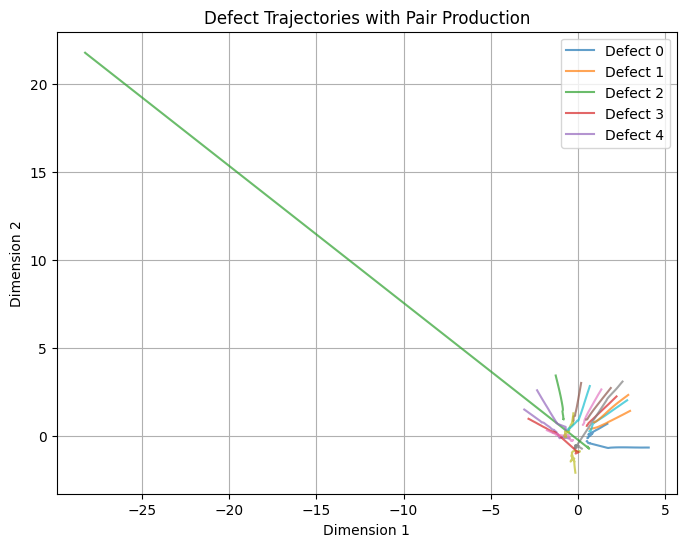

In [ ]:
engine = VDMEngine(dims=2, N_initial=20, steps=100)
engine.run()
engine.plot_trajectories()